In [1]:
# import statements 
import platform
import random
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras
%matplotlib inline
from pysster.One_Hot_Encoder import One_Hot_Encoder

import keras as keras
from keras.models import load_model

from scipy.stats import sem, t
from scipy import mean

import matplotlib
import matplotlib.font_manager as fm
import os
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

Using TensorFlow backend.


# Part 1: Load in data

In [2]:
data_dir ='../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
data_df.head(3)

,off_id,on_id,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,...,stem2,linker,post_linker,on_value,off_value,onoff_value,on_qc,off_qc,onoff_qc,switch_sequence
0,AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...,AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...,smallpox,smallpox_tile_2626,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,AACTGTTTTCCATTTTTTTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAAAAAAATGGAAAACAGTT,AACAGAGGAGA,...,CCATTTTTT,AACCTGGCGGCAGCGCAAAAGATGCG,TAAAGGAGAA,NaN,0.333333,NaN,NaN,NaN,NaN,AAAAAAAAAAAAAAAAAATGGAAAACAGTTAACAGAGGAGAAACTG...
1,AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...,TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...,smallpox,smallpox_tile_2625,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TTAGTAACTGTTTTCCATTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAATGGAAAACAGTTACTAA,AACAGAGGAGA,...,GTTTTCCAT,AACCTGGCGGCAGCGCAAAAGATGCG,TAAAGGAGAA,NaN,NaN,NaN,NaN,NaN,NaN,AAAAAAAAAAAAATGGAAAACAGTTACTAAAACAGAGGAGATTAGT...
2,AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...,CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...,smallpox,smallpox_tile_4951,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,CTAAATTAACAATAGTAGTAATTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAATTACTACTATTGTTAATTTAG,AACAGAGGAGA,...,CAATAGTAG,AACCTGGCGGCAGCGCAAAAGATGCG,TAAAGGAGAA,0.068295,0.000000,0.068295,2.0,1.1,1.1,AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...


In [3]:
qc_cutoff=1.1
data_df = data_df[data_df['on_qc'] >= qc_cutoff].reset_index()
data_df = data_df[data_df['off_qc'] >= qc_cutoff].reset_index()
toehold_seqs = data_df['switch_sequence']
seq_len = len(toehold_seqs[0])
print('Number of remaining sequences: ', len(data_df))

Number of remaining sequences:  91534


In [4]:
# clean up matrix
data_df = data_df[['switch_sequence', 'on_value', 'off_value', 'onoff_value']]

# Part 2: Get sets of 100 bad, 100 good, 100 average/random seqs

In [5]:
best = data_df[data_df['onoff_value'] > data_df['onoff_value'].quantile(.95)]
worst = data_df[data_df['onoff_value'] < data_df['onoff_value'].quantile(.05)]
average = data_df[data_df['onoff_value'] < data_df['onoff_value'].quantile(0.80)]
average = average[average['onoff_value'] > data_df['onoff_value'].quantile(0.20)]

average.head()

,switch_sequence,on_value,off_value,onoff_value
0,AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...,0.068295,0.000000,0.068295
3,AAAAAAACATGAGCTTTGCTTTTTTCAAGTAACAGAGGAGAACTTG...,0.933884,0.514158,0.419726
5,AAAAAAACTGTAATGCGTATGCGGAGGTTAAACAGAGGAGATAACC...,0.729522,0.333333,0.396189
6,AAAAAAAGAAATTGGCCACAGGACCAAAGGAACAGAGGAGACCTTT...,0.151522,0.000000,0.151522
7,AAAAAAAGATTTTTTTCCGATGTTGATACAAACAGAGGAGATGTAT...,0.806247,0.612104,0.194143


In [6]:
# check sizes of each of these
print(len(best))
print(len(worst))
print(len(average)) # good it checks out

4577
4577
54920


In [7]:
num_seqs_to_test = 2500
best_sample = best.sample(n=num_seqs_to_test)
worst_sample = worst.sample(n=num_seqs_to_test)
average_sample = average.sample(n=num_seqs_to_test)

average_sample.head()

,switch_sequence,on_value,off_value,onoff_value
20797,ATGGAATCCATCATGGTCACTGGATCTTCTAACAGAGGAGAAGAAG...,0.807889,0.333333,0.474555
56129,GGGTCGGAGGGCAGTGAGCGAGGGGGCAGAAACAGAGGAGATCTGC...,0.057275,0.000000,0.057275
46518,GACCTTTGTGGAAGAGGCAACTTTGCATACAACAGAGGAGAGTATG...,0.312953,0.032798,0.280156
39462,CTCTCACTAGGCACTGCTTCTGTTATGCTGAACAGAGGAGACAGCA...,0.333333,0.069184,0.264149
58912,GTCAGCAGTACAGAAGTTCACAGCTTCAGCAACAGAGGAGAGCTGA...,0.146422,0.014215,0.132208


# Part 3: Get the one basepair mismatches for each of the seqs

In [8]:
# get just the first 30nt from each sequence so we can build out full (mismatch included) toeholds later
input_col_name = 'switch_sequence'

best_triggers = [seq[0:30] for seq in best_sample[input_col_name]]
worst_triggers = [seq[0:30] for seq in worst_sample[input_col_name]]
average_triggers = [seq[0:30] for seq in average_sample[input_col_name]]

In [9]:
# heavily borrowed code from https://codereview.stackexchange.com/questions/156490/finding-roughly-matching-genome-sequences-in-python-dictionary
# allegedly O(nk^2) where k = size of the sequence

In [10]:
def get_one_bp_mismatches(seq):
    mismatches = []
    bases = ['A','T','G','C']
    for e,i in enumerate(seq):
        for b in bases:
            new_seq = seq[:e] + b + seq[e+1:]
            mismatches.append(new_seq)
    return mismatches

In [11]:
def get_list_of_mismatches_from_list(original_list):
    final_list = []
    for seq_list in [get_one_bp_mismatches(seq) for seq in original_list]:
        for mismatch in seq_list:
            final_list.append(mismatch)
    return final_list

In [12]:
best_mismatches = get_list_of_mismatches_from_list(best_triggers)
worst_mismatches = get_list_of_mismatches_from_list(worst_triggers)
average_mismatches = get_list_of_mismatches_from_list(average_triggers)

In [13]:
print(len(best_mismatches))
print(len(worst_mismatches))
print(len(average_mismatches))
# good this checks out

#print(best_mismatches[1:20])
#print(worst_mismatches[1:20])
#print(average_mismatches[1:20])

300000
300000
300000


In [14]:
# now turn 30nt back to 59nt
rbs = 'AACAGAGGAGA'
start_codon = 'ATG'

# Make function to generate reverse compliment of the DNA strand
def make_rev_complement(string):
    new_str = ''
    for s in string:
        char = ''
        if s == 'A':
            char = 'T'
        elif s == 'T':
            char = 'A'
        elif s == 'C':
            char = 'G'
        elif s == 'G':
            char = 'C'
        else:
            print('UH OH! Character not A, T, C, or G')
        new_str += char
    new_str = new_str[::-1]
    return new_str

# Make function to actually turn trigger into toehold
def turn_switch_to_toehold(switch):
    stem1 = make_rev_complement(switch[24:30])
    stem2 = make_rev_complement(switch[12:21])
    toehold = switch + rbs + stem1 + start_codon + stem2
    return toehold

In [15]:
best_full_toeholds = [turn_switch_to_toehold(x) for x in best_mismatches]
worst_full_toeholds = [turn_switch_to_toehold(x) for x in worst_mismatches]
average_full_toeholds = [turn_switch_to_toehold(x) for x in average_mismatches]

# Part 4: One hot encode all these sequences

In [16]:
alph_letters = sorted('ATCG')
alph = list(alph_letters)

# one-hot encode and use pysster (very fast and simple encoding)  
one = One_Hot_Encoder(alph_letters)
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq) 
    return one_hot_seq

# now convert the data into one_hot_encoding 
X_best = np.stack([_get_one_hot_encoding(s) for s in best_full_toeholds]).astype(np.float32)
X_worst = np.stack([_get_one_hot_encoding(s) for s in worst_full_toeholds]).astype(np.float32)
X_avg = np.stack([_get_one_hot_encoding(s) for s in average_full_toeholds]).astype(np.float32)

In [17]:
print(np.shape(X_best))
print(np.shape(X_worst))
print(np.shape(X_avg))

(300000, 59, 4)
(300000, 59, 4)
(300000, 59, 4)


# Part 5: Load final model

In [18]:
model_dir = 'trained_model/'
final_model_path = model_dir + 'final_trained_model.h5'
final_weights_path = model_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [19]:
# visually inspect architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 59, 4)        0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 59, 10)       210         input_2[0][0]                    
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 59, 5)        155         conv_0[0][0]                     
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 295)          0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_4 

# Part 5: Predict the changes in ON/OFF for each of these one bp mismatches

In [20]:
best_predictions = model.predict(X_best)
worst_predictions = model.predict(X_worst)
average_predictions = model.predict(X_avg)

In [21]:
def add_to_dataframe(predictions, data_df):
    on_preds = predictions[0]
    off_preds = predictions[1]

    data_df['on_preds'] = on_preds.flatten()
    data_df['off_preds'] = off_preds.flatten()
    return(data_df)

In [22]:
best_run_thru_model = add_to_dataframe(best_predictions, pd.DataFrame(best_mismatches))
worst_run_thru_model = add_to_dataframe(worst_predictions, pd.DataFrame(worst_mismatches))
average_run_thru_model = add_to_dataframe(average_predictions, pd.DataFrame(average_mismatches))

#print(best_run_thru_model.head(8))
#print(worst_run_thru_model.head(8))
print(average_run_thru_model.head(8))

                                0  on_preds  off_preds
0  ATGGAATCCATCATGGTCACTGGATCTTCT  0.828292   0.255999
1  TTGGAATCCATCATGGTCACTGGATCTTCT  0.823317   0.226688
2  GTGGAATCCATCATGGTCACTGGATCTTCT  0.826970   0.241141
3  CTGGAATCCATCATGGTCACTGGATCTTCT  0.820726   0.209997
4  AAGGAATCCATCATGGTCACTGGATCTTCT  0.833495   0.265335
5  ATGGAATCCATCATGGTCACTGGATCTTCT  0.828292   0.255999
6  AGGGAATCCATCATGGTCACTGGATCTTCT  0.837496   0.271634
7  ACGGAATCCATCATGGTCACTGGATCTTCT  0.830411   0.242969


In [23]:
# can we get the standard deviation across all of the base pairs for each of the 100 sequences (one bp at a time)
def get_std_dev_at_each_bp(df):
    seq_len = len(df.iloc[0,0]) # as an example, get seq len of the first sequence
    hardcode_num_base_seqs = num_seqs_to_test
    alph_len = 4 # hard coded (A, T, C, G)
    all_ON_std_devs = np.zeros((hardcode_num_base_seqs, seq_len))
    all_OFF_std_devs = np.zeros((hardcode_num_base_seqs, seq_len))
    curr_index_of_seqs = 0
    for row in range(0, hardcode_num_base_seqs):
        for col in range(0, seq_len):
            ON_for_current_seqs = df.iloc[curr_index_of_seqs:(curr_index_of_seqs+4),1]
            OFF_for_current_seqs = df.iloc[curr_index_of_seqs:(curr_index_of_seqs+4),2]

            ON_std_dev = np.std(ON_for_current_seqs)
            OFF_std_dev = np.std(OFF_for_current_seqs)

            all_ON_std_devs[row, col] = ON_std_dev
            all_OFF_std_devs[row, col] = OFF_std_dev

            curr_index_of_seqs = curr_index_of_seqs + 4
    
    return([all_ON_std_devs, all_OFF_std_devs])


In [24]:
ON_best_matrix_of_stds, OFF_best_matrix_of_stds = get_std_dev_at_each_bp(best_run_thru_model)
ON_worst_matrix_of_stds, OFF_worst_matrix_of_stds = get_std_dev_at_each_bp(worst_run_thru_model)
ON_average_matrix_of_stds, OFF_average_matrix_of_stds = get_std_dev_at_each_bp(average_run_thru_model)

In [25]:
def get_means_and_bounds_of_stds(matrix):
    
    means = []
    conf_int_lower_bound = []
    conf_int_upper_bound = []

    for column in matrix.T:
        confidence = 0.95 # compute 95% confidence interval
        n = len(column)
        m = mean(column)
        std_err = sem(column)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        means.append(m)
        conf_int_lower_bound.append(m-h)
        conf_int_upper_bound.append(m+h)
        
    return([means, conf_int_lower_bound, conf_int_upper_bound])


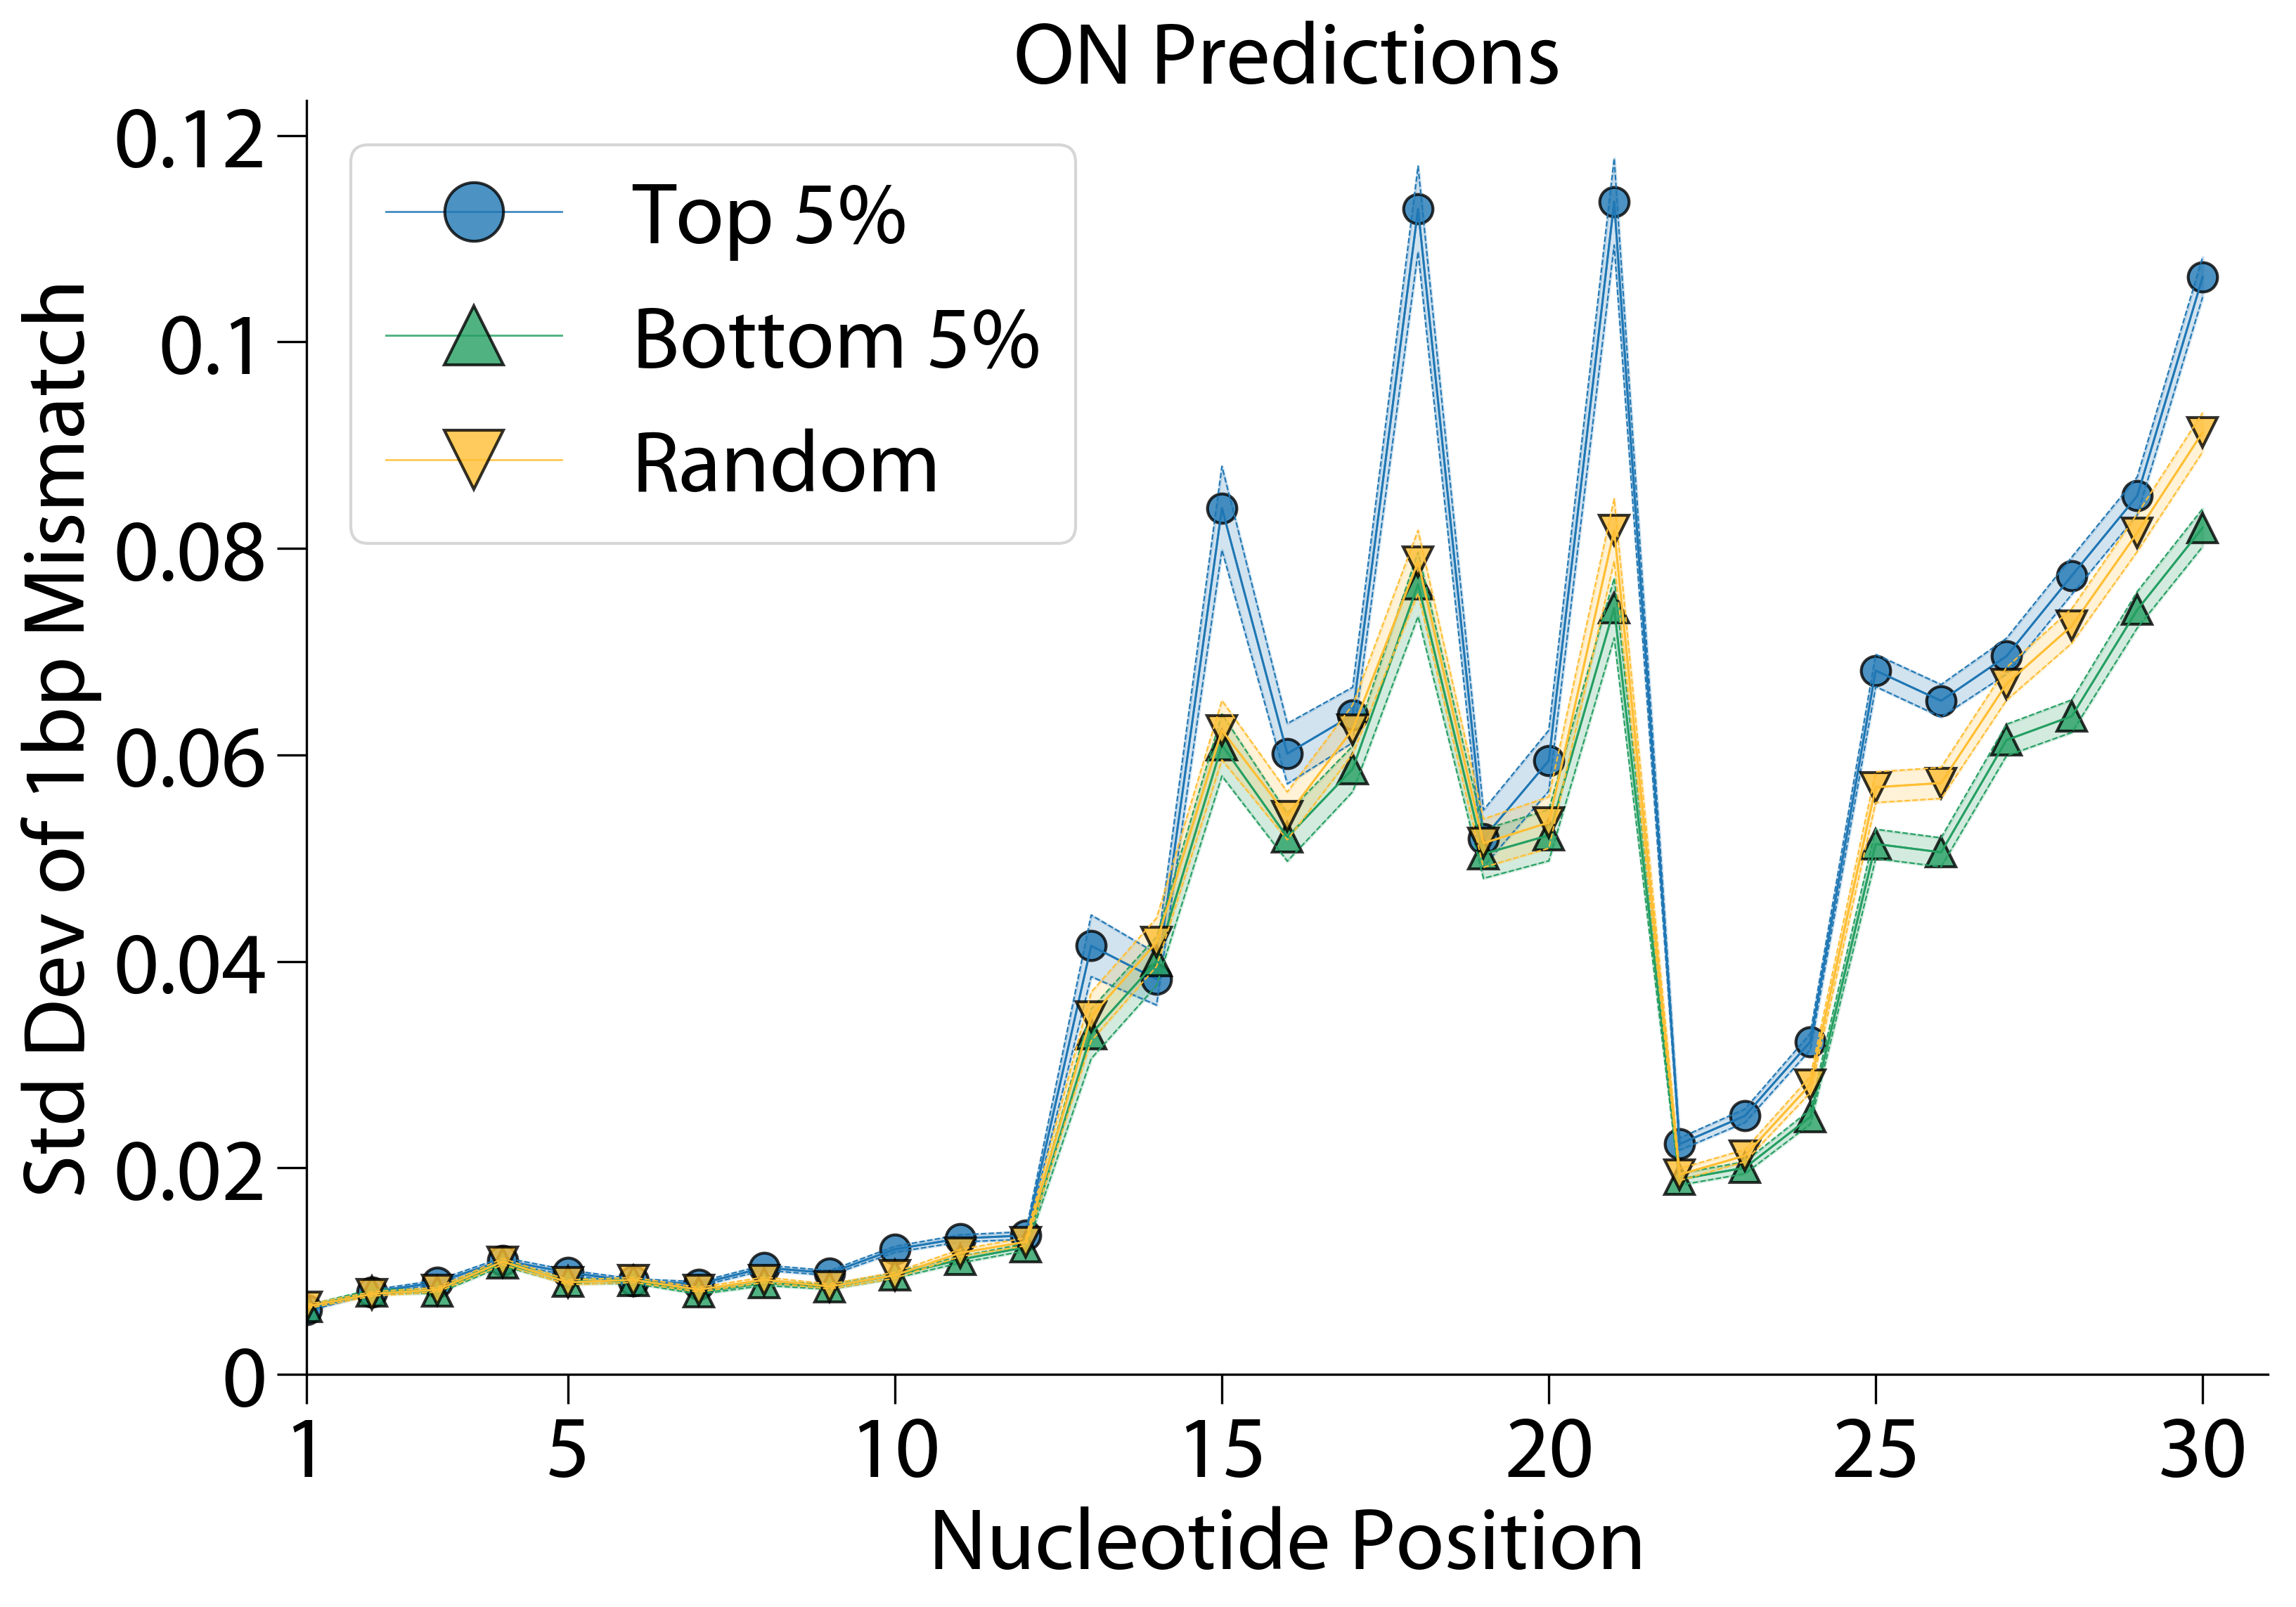

In [26]:
# plot ON
fig, ax = plt.subplots(figsize = (12,8), dpi = 300)

x = list(range(0, 30))

# plot best
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(ON_best_matrix_of_stds)
plt.plot(x, means, 'o-', label = 'Top 5%', linewidth = 0.7, markersize=10, markeredgecolor = 'black', color = 'tab:blue', alpha = 0.8)
plt.plot(x, means, '-', color = 'tab:blue', linewidth = 0.7)
plt.plot(x, conf_int_lower_bound, '--', linewidth=0.5,  color = 'tab:blue')
plt.plot(x, conf_int_upper_bound, '--', linewidth=0.5,  color = 'tab:blue')
ax.fill_between(x, conf_int_lower_bound, conf_int_upper_bound, color = 'tab:blue', alpha = 0.2)

# plot worst
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(ON_worst_matrix_of_stds)
plt.plot(x, means, '^-', color = '#259F62', linewidth = 0.7, label = 'Bottom 5%',markeredgecolor = 'black', markersize=10, alpha = 0.8)
plt.plot(x, means, '-', color = '#259F62', linewidth = 0.7)
plt.plot(x, conf_int_lower_bound, '--', linewidth=0.5, color = '#259F62')
plt.plot(x, conf_int_upper_bound, '--', linewidth=0.5, color = '#259F62')
ax.fill_between(x, conf_int_lower_bound, conf_int_upper_bound, color = '#259F62', alpha = 0.2)

# plot random
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(ON_average_matrix_of_stds)
plt.plot(x, means, 'v-', color='#FFBE33', label = 'Random', linewidth = 0.7, markeredgecolor = 'black',markersize=10, alpha = 0.8)
plt.plot(x, means, '-', color = '#FFBE33', linewidth = 0.7)
plt.plot(x, conf_int_lower_bound, '--', color='#FFBE33', linewidth=0.5)
plt.plot(x, conf_int_upper_bound, '--', color='#FFBE33', linewidth=0.5)
ax.fill_between(x, conf_int_lower_bound, conf_int_upper_bound, color = '#FFBE33', alpha = 0.2)

ax.set_title('ON Predictions', **axis_font, fontsize = 30)
legend_prop = fm.FontProperties(fname=fpath, size = 30)
plt.legend(loc="upper left", markerscale = 2, prop=legend_prop)
ax.set_xlabel('Nucleotide Position', **axis_font, fontsize=30)
ax.set_ylabel("Std Dev of 1bp Mismatch", **axis_font, fontsize=30)

plt.xlim([1, 30])
plt.tick_params(length = 10)

ax.set_xticks([0, 4, 9, 14, 19, 24, 29])
ax.set_xticklabels(labels = [1, 5, 10, 15, 20, 25, 30], **axis_font, fontsize = 30)

ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])
ax.set_yticklabels(labels = [0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12],  **axis_font, fontsize = 30)

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

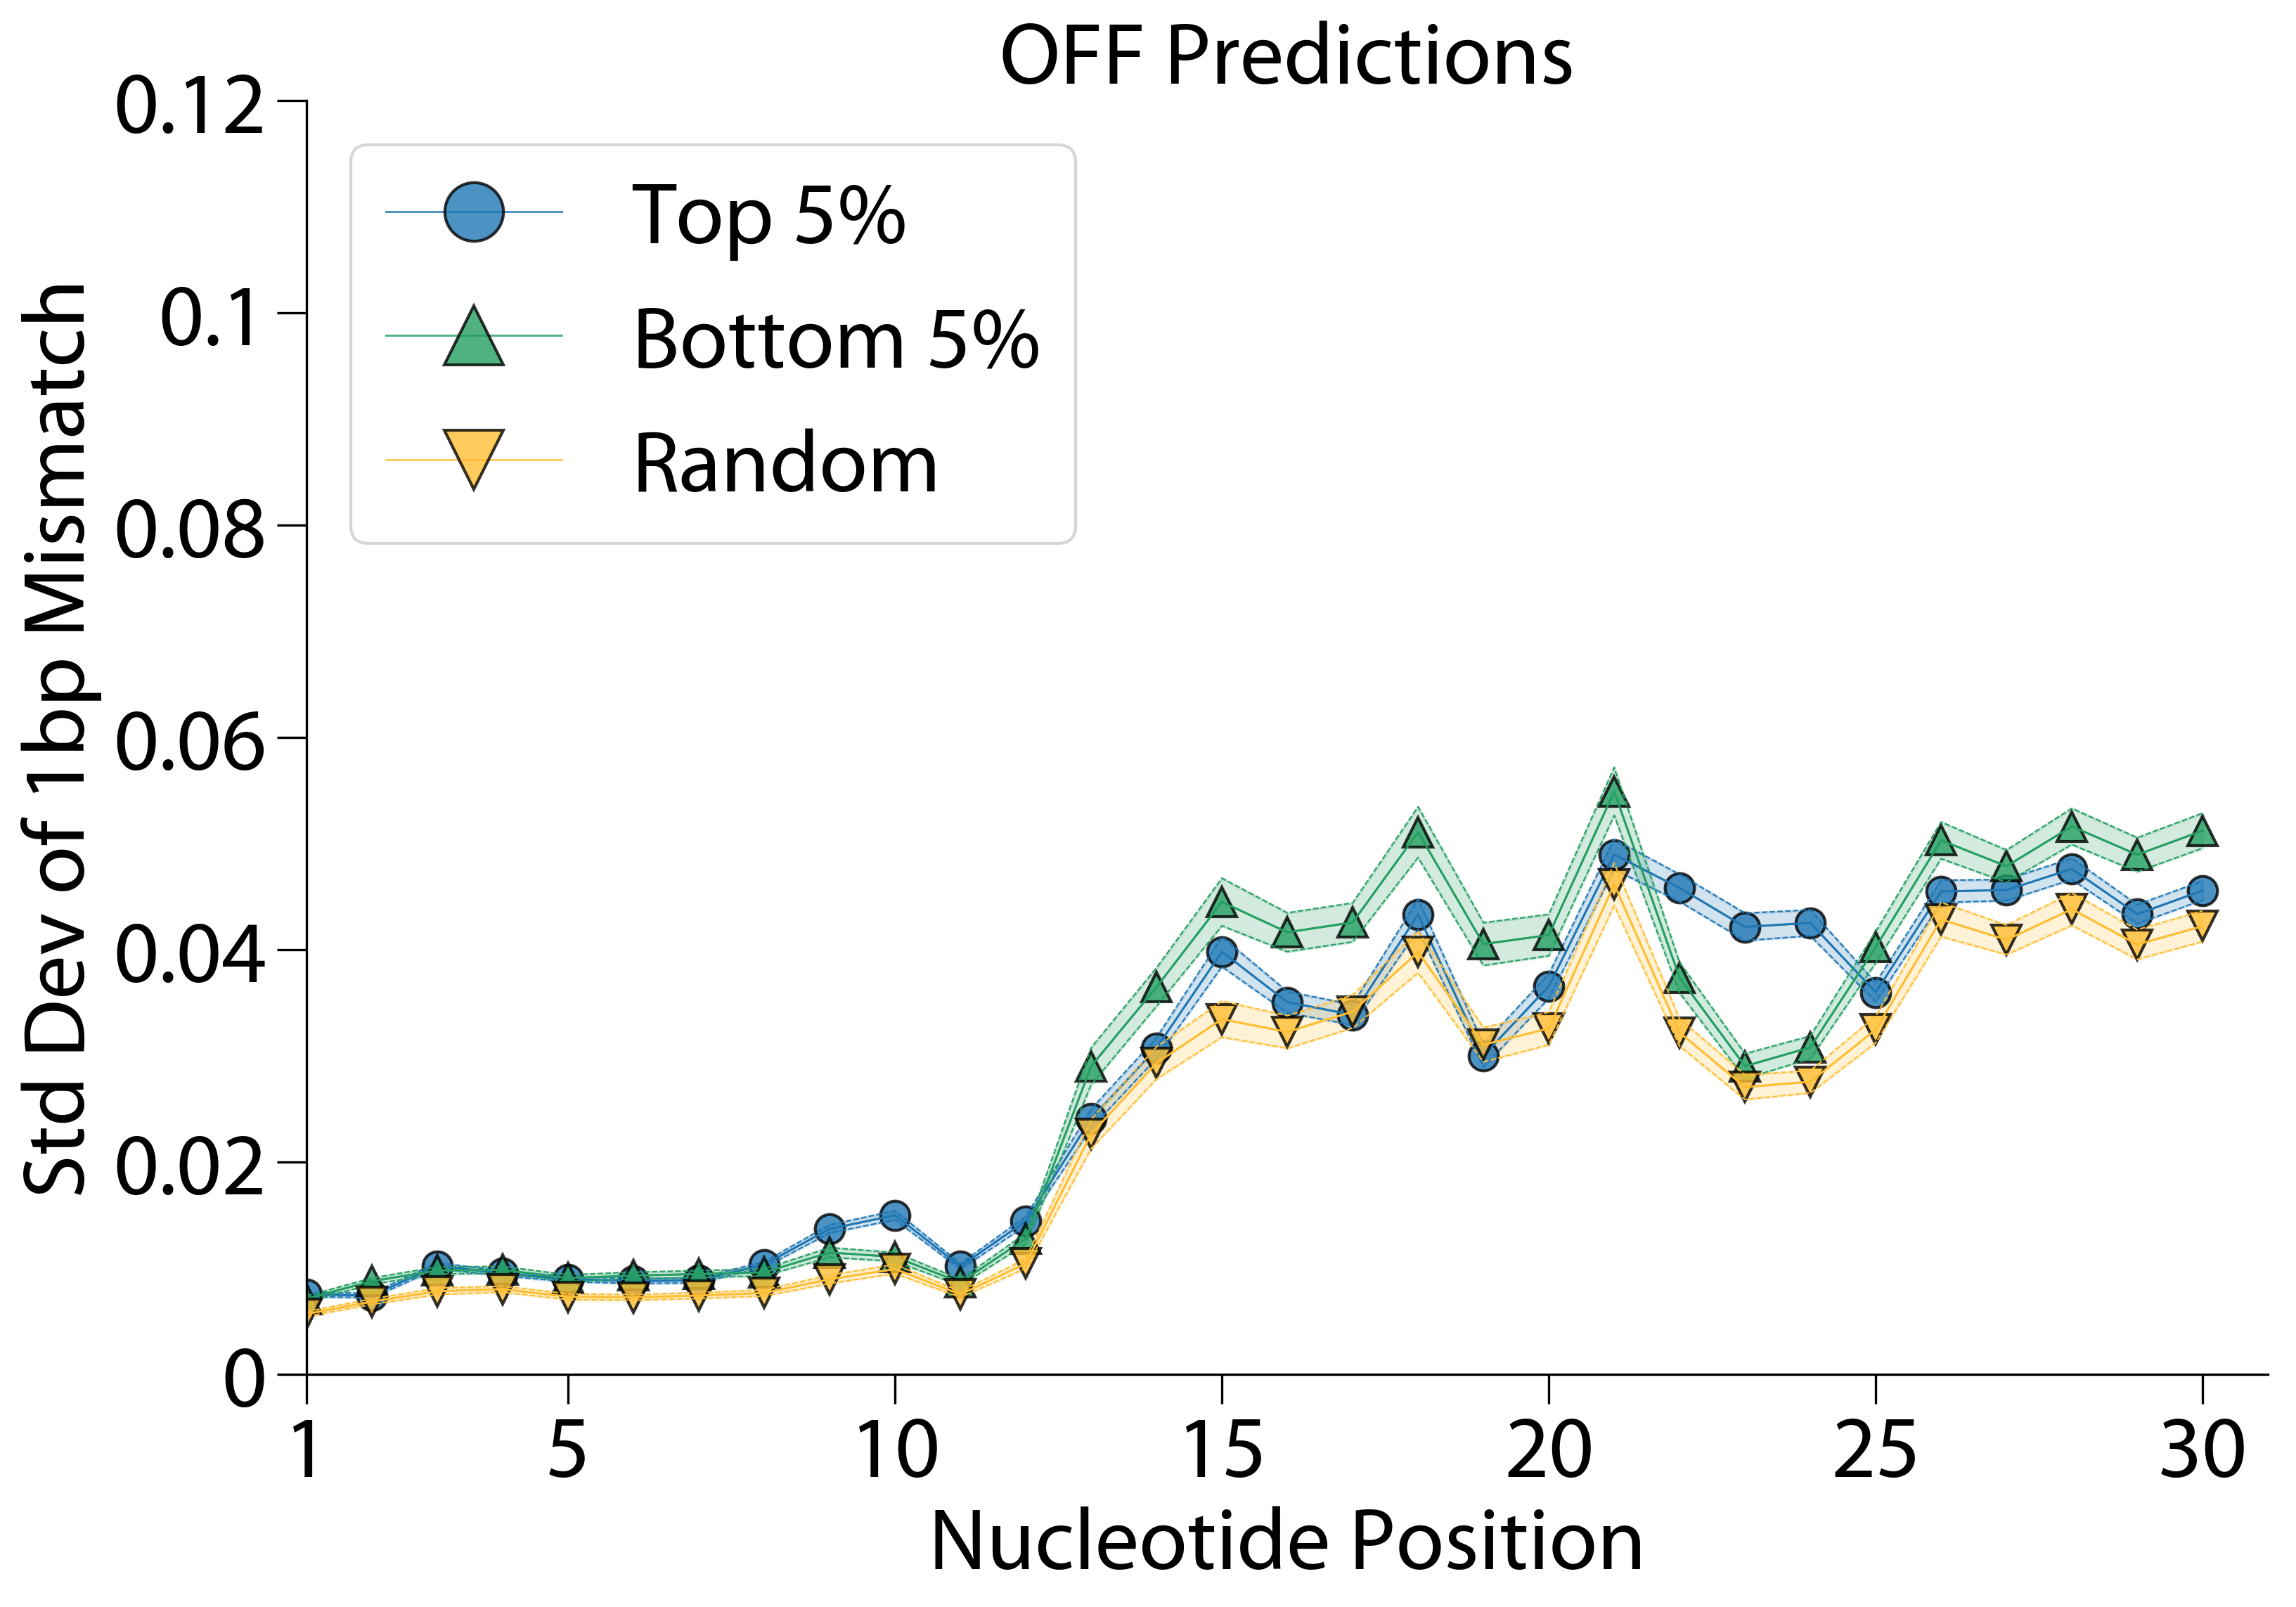

In [27]:
# plot OFF
fig, ax = plt.subplots(figsize = (12,8), dpi = 300)
hfont = {'fontname':'Myriad Pro'}

x = list(range(0, 30))

# plot best
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(OFF_best_matrix_of_stds)
plt.plot(x, means, 'o-', label = 'Top 5%', linewidth = 0.7, markeredgecolor = 'black',markersize=10,  color = 'tab:blue', alpha = 0.8)
plt.plot(x, means, '-', color = 'tab:blue', linewidth = 0.7)
plt.plot(x, conf_int_lower_bound, '--', linewidth=0.5,  color = 'tab:blue')
plt.plot(x, conf_int_upper_bound, '--', linewidth=0.5,  color = 'tab:blue')
ax.fill_between(x, conf_int_lower_bound, conf_int_upper_bound, color = 'tab:blue', alpha = 0.2)

# plot worst
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(OFF_worst_matrix_of_stds)
plt.plot(x, means, '^-', label = 'Bottom 5%', linewidth = 0.7, markeredgecolor = 'black',markersize=10, color = '#259F62', alpha = 0.8)
plt.plot(x, means, '-', color = '#259F62', linewidth = 0.7)
plt.plot(x, conf_int_lower_bound, '--', linewidth=0.5, color = '#259F62')
plt.plot(x, conf_int_upper_bound, '--', linewidth=0.5, color = '#259F62')
ax.fill_between(x, conf_int_lower_bound, conf_int_upper_bound, color = '#259F62', alpha = 0.2)

# plot random
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(OFF_average_matrix_of_stds)
plt.plot(x, means, 'v-', label = 'Random', linewidth = 0.7, markeredgecolor = 'black', markersize=10, color='#FFBE33', alpha = 0.8)
plt.plot(x, means, '-', color = '#FFBE33', linewidth = 0.7)
plt.plot(x, conf_int_lower_bound, '--', linewidth=0.5, color='#FFBE33')
plt.plot(x, conf_int_upper_bound, '--', linewidth=0.5, color='#FFBE33')
ax.fill_between(x, conf_int_lower_bound, conf_int_upper_bound, color = '#FFBE33', alpha = 0.2)

ax.set_title('OFF Predictions', **axis_font, fontsize = 30)
plt.legend(loc="upper left", markerscale = 2, prop=legend_prop)
ax.set_xlabel('Nucleotide Position', **axis_font,fontsize=30)
ax.set_ylabel("Std Dev of 1bp Mismatch", **axis_font,fontsize=30)

plt.xlim([1, 30])
plt.tick_params(length = 10)

ax.set_xticks([0, 4, 9, 14, 19, 24, 29])
ax.set_xticklabels(labels = [1, 5, 10, 15, 20, 25, 30], **axis_font, fontsize = 30)

ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])
ax.set_yticklabels(labels = [0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12],  **axis_font, fontsize = 30)

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)